In [16]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader

import importlib
import utils.preprocess
import utils.baseline
importlib.reload(utils.preprocess)
importlib.reload(utils.baseline)

from utils.preprocess import DataWindow
from utils.baseline import Baseline, MultiStepBaseline, RepeatBaseline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# データのダウンロード
train_df = pd.read_csv('../data/train.csv', index_col=0)
val_df = pd.read_csv('../data/val.csv', index_col=0)
test_df = pd.read_csv('../data/test.csv', index_col=0)

In [4]:
# データの確認
train_df

,temp,clouds_all,traffic_volume,day_sin,day_cos
0,0.760019,0.00,0.758755,0.146447,0.853553
1,0.738174,0.00,0.560765,0.250000,0.933013
2,0.698884,0.00,0.463513,0.370590,0.982963
3,0.668238,0.00,0.370029,0.500000,1.000000
4,0.643093,0.00,0.325101,0.629410,0.982963
...,...,...,...,...,...
12280,0.422599,0.90,0.599972,0.250000,0.066987
12281,0.421656,0.75,0.561881,0.146447,0.146447
12282,0.436272,0.90,0.567881,0.066987,0.250000
12283,0.439415,0.75,0.644482,0.017037,0.370590


## 13.2 ベースラインモデルを実装する

### 13.2.1 シングルステップのベースラインモデル

In [5]:
# シングルステップモデル用のデータウィンドウの作成（次の時間ステップを予測するモデル）
single_step_window = DataWindow(
    input_width=1, 
    label_width=1, 
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['traffic_volume']
)

# プロット時に可視化できるモデルの予測値の数を増やすために、より広いウィンドウも定義
wide_window = DataWindow(
    input_width=24, 
    label_width=24, 
    shift=1, 
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['traffic_volume']
)

In [6]:
# 訓練データセットの各列の名前とインデックスが含まれたdictを生成
column_indices = {name: i for i, name in enumerate(train_df.columns)}

# Baselineクラスに目的変数列のインデックスを渡す
baseline_last = Baseline(label_index=column_indices['traffic_volume'])

In [7]:
def evaluate_model(model: nn.Module, dataloader: DataLoader) -> tuple[float, float]:
    """
    モデルの評価を行う関数。

    Args:
        model (nn.Module): 評価するモデル
        dataloader (DataLoader): 評価用データローダー

    Returns:
        tuple[float, float]: MSEおよびMAEの評価結果
    """
    model.eval()
    total_mse = 0.0
    total_mae = 0.0
    num_batches = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            predictions = model(inputs)
            
            # PyTorchの関数で直接テンソルを評価
            mse = torch.nn.functional.mse_loss(predictions, targets)
            mae = torch.nn.functional.l1_loss(predictions, targets)

            total_mse += mse.item()  # item()で数値に変換
            total_mae += mae.item()
            num_batches += 1

    # 平均値を返す
    return total_mse / num_batches, total_mae / num_batches


In [8]:
# 評価用とテスト用のdataloaderを作成
val_dataloader = single_step_window.val
test_dataloader = single_step_window.val

# validationデータとtestデータで評価を行う
val_mse, val_mae = evaluate_model(baseline_last, val_dataloader)
test_mse, test_mae = evaluate_model(baseline_last, test_dataloader)

val_performance  = {'Baseline - Last': {'MSE': val_mse, 'MAE': val_mae}}
performance = {'Baseline - Last:': {'MSE': test_mse, 'MAE': test_mae}}

print("Validation Performance:", val_performance)
print("Test Performance:", performance)

Validation Performance: {'Baseline - Last': {'MSE': 0.013298145093193109, 'MAE': 0.08298061412166466}}
Test Performance: {'Baseline - Last:': {'MSE': 0.013316997944970023, 'MAE': 0.08303341293199495}}


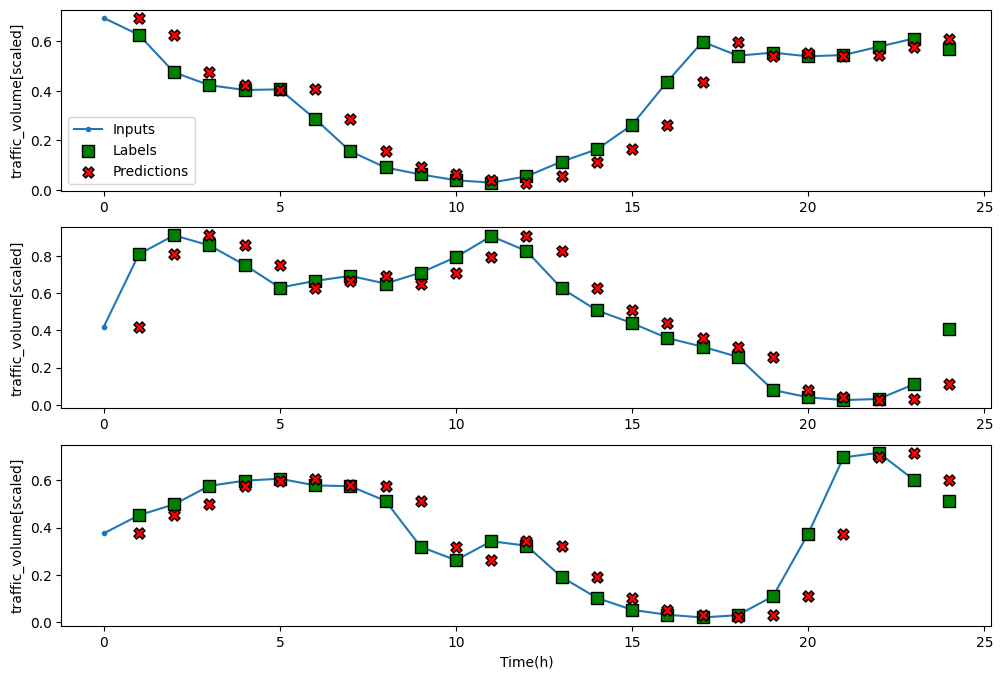

In [9]:
# 予測値の可視化(データ点を3つ以上表示する場合はwide_windowを使う)
wide_window.plot(baseline_last)

### 13.2.2 マルチステップのベースラインモデル

- 最後の既知の値を予測する

In [10]:
# マルチステップモデル用のデータウィンドウの作成（24時間分の入力から次の24時間の交通量を予測するモデル）
multi_window = DataWindow(
    input_width=24,
    label_width=24,
    shift=24,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['traffic_volume']
)

In [13]:
# MultiStepBaselineクラスに目的変数列のインデックスを渡す
ms_baseline_last = MultiStepBaseline(label_index=column_indices['traffic_volume'])

# 評価用とテスト用のdataloaderを作成
val_dataloader = multi_window.val
test_dataloader = multi_window.val

# validationデータとtestデータで評価を行う
val_mse, val_mae = evaluate_model(ms_baseline_last, val_dataloader)
test_mse, test_mae = evaluate_model(ms_baseline_last, test_dataloader)

val_performance  = {'Baseline - Last': {'MSE': val_mse, 'MAE': val_mae}}
performance = {'Baseline - Last:': {'MSE': test_mse, 'MAE': test_mae}}

print("Validation Performance:", val_performance)
print("Test Performance:", performance)

Validation Performance: {'Baseline - Last': {'MSE': 0.14938280977513813, 'MAE': 0.30851644318585003}}
Test Performance: {'Baseline - Last:': {'MSE': 0.15006674087922509, 'MAE': 0.30930952850831755}}


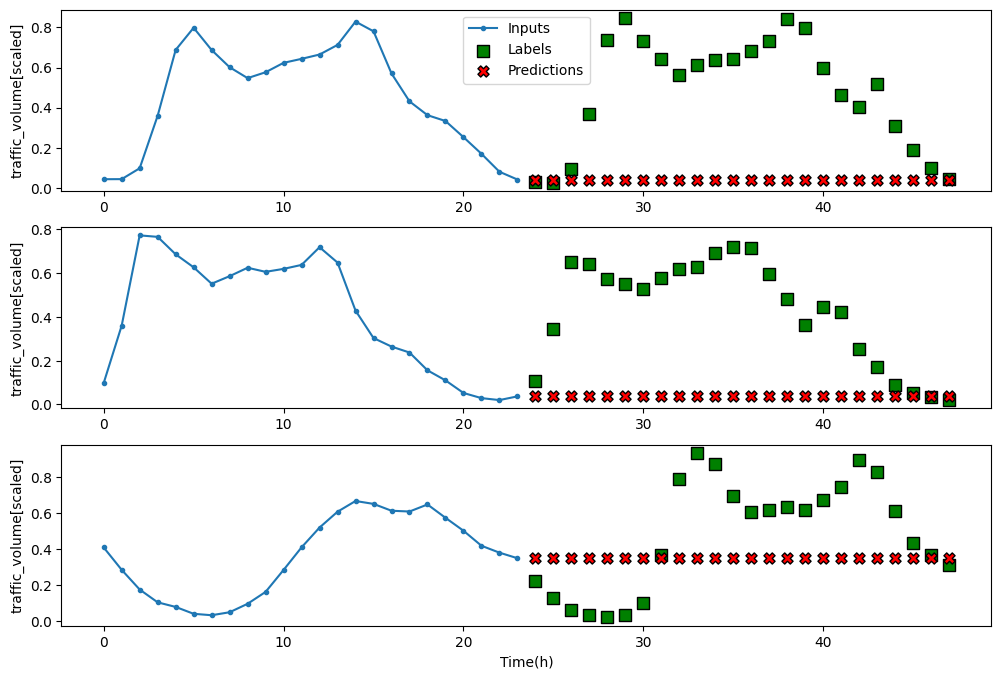

In [14]:
# 予測値の可視化
multi_window.plot(ms_baseline_last)

- 入力シーケンスを繰り返す

In [17]:
# RepeatBaselineクラスに目的変数列のインデックスを渡す
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

# 評価用とテスト用のdataloaderを作成
val_dataloader = multi_window.val
test_dataloader = multi_window.val

# validationデータとtestデータで評価を行う
val_mse, val_mae = evaluate_model(ms_baseline_repeat, val_dataloader)
test_mse, test_mae = evaluate_model(ms_baseline_repeat, test_dataloader)

val_performance  = {'Baseline - Last': {'MSE': val_mse, 'MAE': val_mae}}
performance = {'Baseline - Last:': {'MSE': test_mse, 'MAE': test_mae}}

print("Validation Performance:", val_performance)
print("Test Performance:", performance)

Validation Performance: {'Baseline - Last': {'MSE': 0.022562814423592266, 'MAE': 0.0816413778982578}}
Test Performance: {'Baseline - Last:': {'MSE': 0.022488608212987763, 'MAE': 0.08158822586640306}}


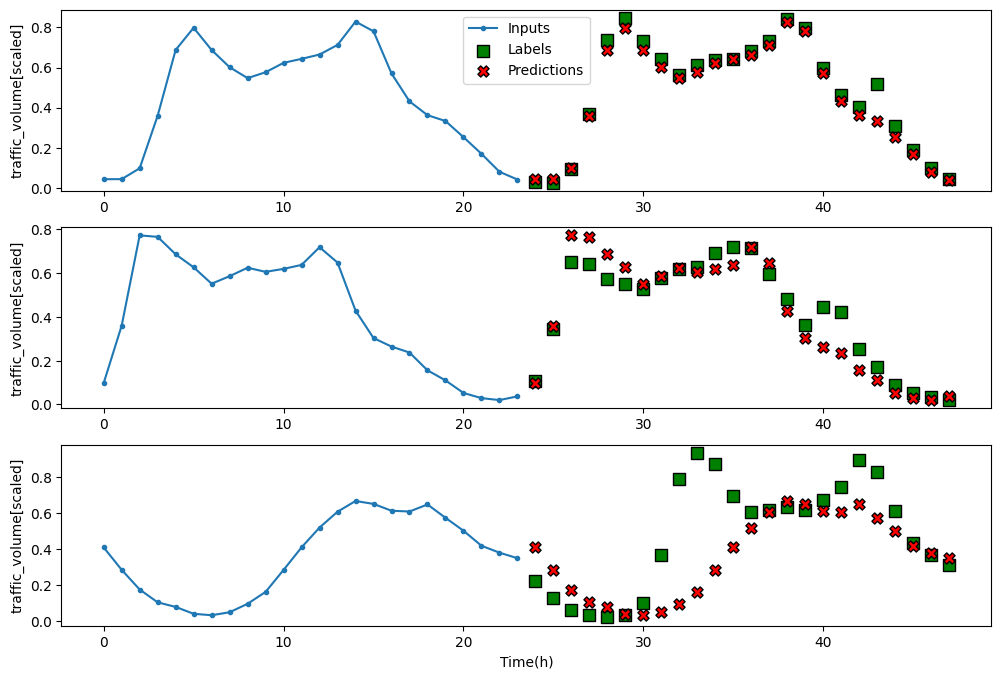

In [18]:
multi_window.plot(ms_baseline_repeat)

### 13.2.3 多出力のベースラインモデル

In [19]:
# シングルステップモデル用のデータウィンドウの作成（次の時間ステップを予測するモデル）
mo_single_step_window = DataWindow(
    input_width=1, 
    label_width=1, 
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['temp', 'traffic_volume']
)

# プロット時に可視化できるモデルの予測値の数を増やすために、より広いウィンドウも定義
mo_wide_window = DataWindow(
    input_width=24, 
    label_width=24, 
    shift=1, 
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['temp', 'traffic_volume']
)

In [20]:
# Baselineクラスに目的変数列のインデックスを渡す
mo_baseline_last = Baseline(label_index=[0, 2])

# 評価用とテスト用のdataloaderを作成
mo_val_dataloader = mo_single_step_window.val
mo_test_dataloader = mo_single_step_window.val

# validationデータとtestデータで評価を行う
val_mse, val_mae = evaluate_model(mo_baseline_last, mo_val_dataloader)
test_mse, test_mae = evaluate_model(mo_baseline_last, mo_test_dataloader)

val_performance  = {'Baseline - Last': {'MSE': val_mse, 'MAE': val_mae}}
performance = {'Baseline - Last:': {'MSE': test_mse, 'MAE': test_mae}}

print("Validation Performance:", val_performance)
print("Test Performance:", performance)

Validation Performance: {'Baseline - Last': {'MSE': 0.006845245144160634, 'MAE': 0.0481712516058575}}
Test Performance: {'Baseline - Last:': {'MSE': 0.006858713319525122, 'MAE': 0.048230571367523886}}


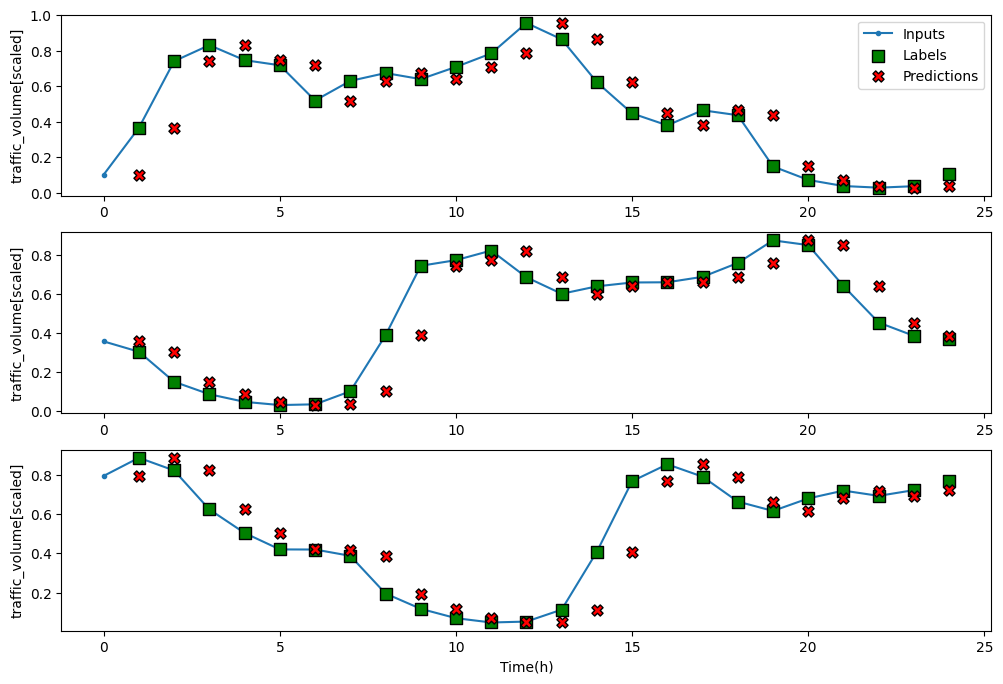

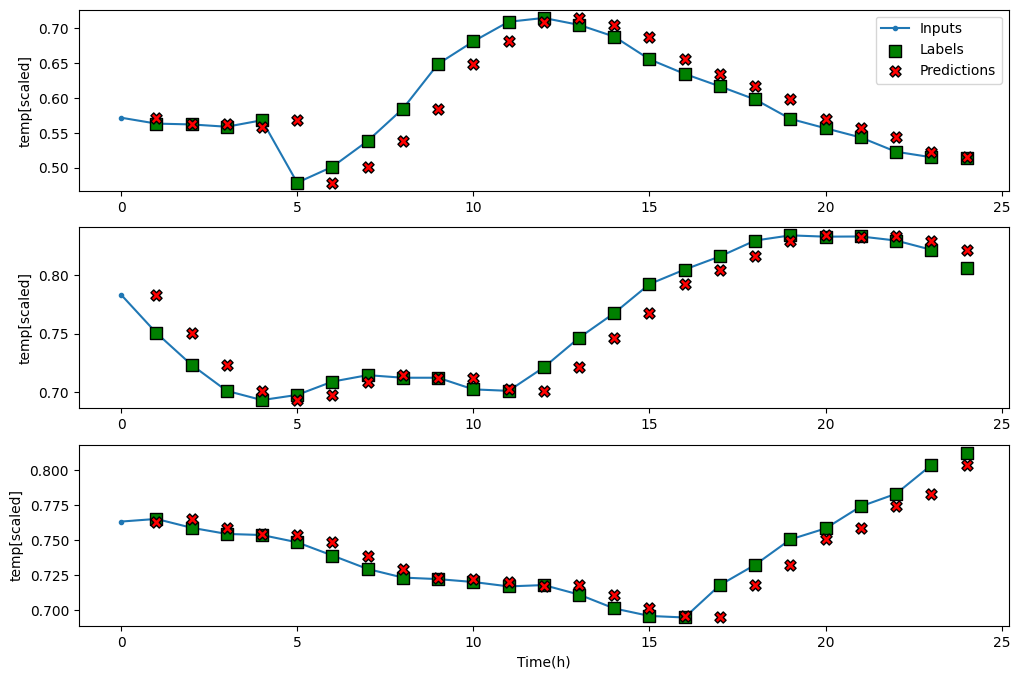

In [21]:
# 予測値の可視化
mo_wide_window.plot(mo_baseline_last)
mo_wide_window.plot(mo_baseline_last, plot_col='temp')